## Remove old Weaviate DB files

In [1]:
!rm -rf ~/.local/share/weaviate

'rm' is not recognized as an internal or external command,
operable program or batch file.


# Approximate Nearest Neighbors

In [1]:
from random import random, randint
from math import floor, log
import networkx as nx
import numpy as np
import matplotlib as mtplt
from matplotlib import pyplot as plt
from utils import *

vec_num = 40 # Number of vectors (nodes)
dim = 2 ## Dimention. Set to be 2. All the graph plots are for dim 2. If changed, then plots should be commented. 
m_nearest_neighbor = 2 # M Nearest Neigbor used in construction of the Navigable Small World (NSW)

vec_pos = np.random.uniform(size=(vec_num, dim))

### Query Vector

In [2]:
## Query
query_vec = [0.5, 0.5]

nodes = []
nodes.append(("Q",{"pos": query_vec}))

G_query = nx.Graph()
G_query.add_nodes_from(nodes)

print("nodes = ", nodes, flush=True)

pos_query=nx.get_node_attributes(G_query,'pos')

nodes =  [('Q', {'pos': [0.5, 0.5]})]


## Brute Force

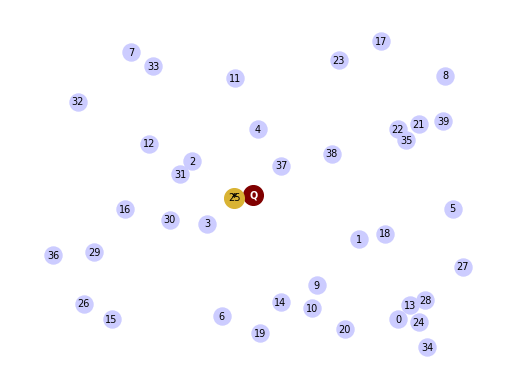

In [3]:
(G_lin, G_best) = nearest_neigbor(vec_pos,query_vec)

pos_lin=nx.get_node_attributes(G_lin,'pos')
pos_best=nx.get_node_attributes(G_best,'pos')

fig, axs = plt.subplots()

nx.draw(G_lin, pos_lin, with_labels=True, node_size=150, node_color=[[0.8,0.8,1]], width=0.0, font_size=7, ax = axs)
nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.5,0,0]], font_color='white', width=0.5, font_size=7, font_weight='bold', ax = axs)
nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)

### HNSW Construction

layer_i =  3


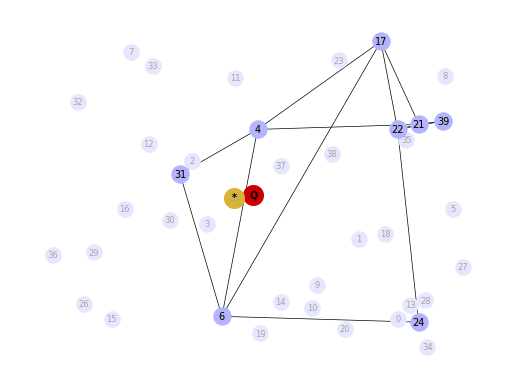

layer_i =  2


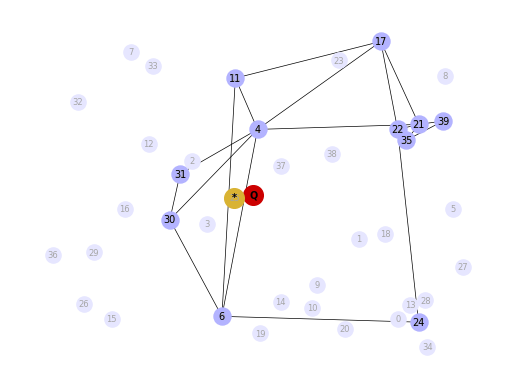

layer_i =  1


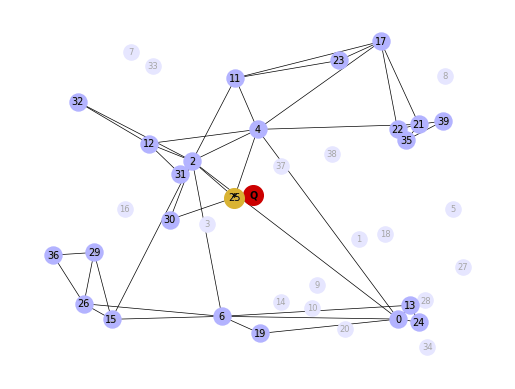

layer_i =  0


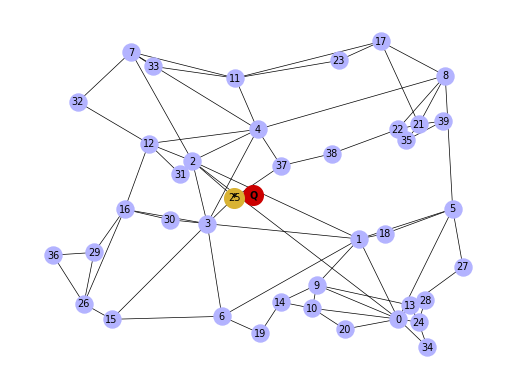

In [4]:
GraphArray = construct_HNSW(vec_pos,m_nearest_neighbor)

for layer_i in range(len(GraphArray)-1,-1,-1):
    fig, axs = plt.subplots()

    print("layer_i = ", layer_i)
        
    if layer_i>0:
        pos_layer_0 = nx.get_node_attributes(GraphArray[0],'pos')
        nx.draw(GraphArray[0], pos_layer_0, with_labels=True, node_size=120, node_color=[[0.9,0.9,1]], width=0.0, font_size=6, font_color=(0.65,0.65,0.65), ax = axs)

    pos_layer_i = nx.get_node_attributes(GraphArray[layer_i],'pos')
    nx.draw(GraphArray[layer_i], pos_layer_i, with_labels=True, node_size=150, node_color=[[0.7,0.7,1]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.8,0,0]], width=0.5, font_size=7, font_weight='bold', ax = axs)
    nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)
    plt.show()

### HNSW Search

layer_i =  3


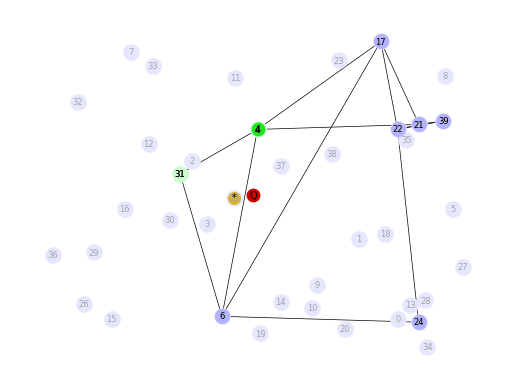

layer_i =  2


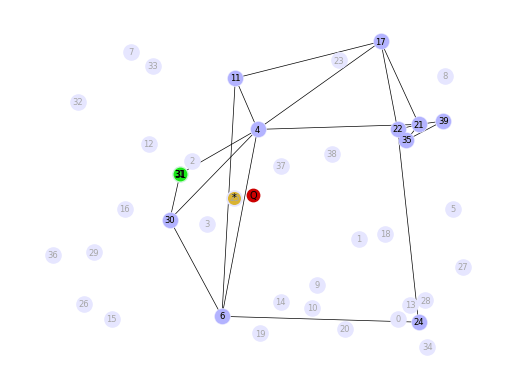

layer_i =  1


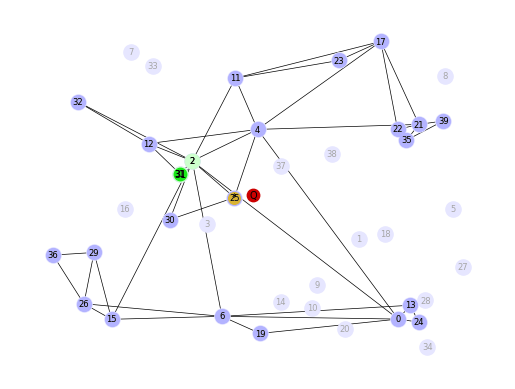

layer_i =  0


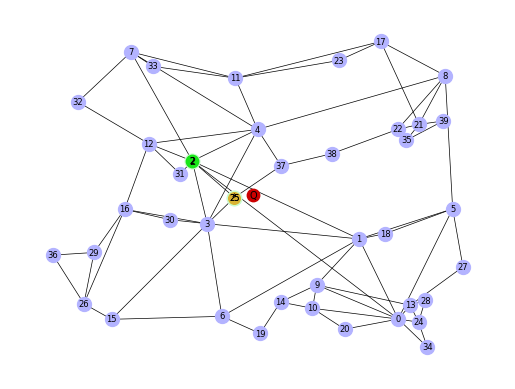

In [5]:
(SearchPathGraphArray, EntryGraphArray) = search_HNSW(GraphArray,G_query)

for layer_i in range(len(GraphArray)-1,-1,-1):
    fig, axs = plt.subplots()

    print("layer_i = ", layer_i)
    G_path_layer = SearchPathGraphArray[layer_i]
    pos_path = nx.get_node_attributes(G_path_layer,'pos')
    G_entry = EntryGraphArray[layer_i]
    pos_entry = nx.get_node_attributes(G_entry,'pos')

    if layer_i>0:
            pos_layer_0 = nx.get_node_attributes(GraphArray[0],'pos')
            nx.draw(GraphArray[0], pos_layer_0, with_labels=True, node_size=120, node_color=[[0.9,0.9,1]], width=0.0, font_size=6, font_color=(0.65,0.65,0.65), ax = axs)

    pos_layer_i = nx.get_node_attributes(GraphArray[layer_i],'pos')
    nx.draw(GraphArray[layer_i], pos_layer_i, with_labels=True, node_size=100, node_color=[[0.7,0.7,1]], width=0.5, font_size=6, ax = axs)
    nx.draw(G_path_layer, pos_path, with_labels=True, node_size=110, node_color=[[0.8,1,0.8]], width=0.5, font_size=6, ax = axs)
    nx.draw(G_query, pos_query, with_labels=True, node_size=80, node_color=[[0.8,0,0]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_best, pos_best, with_labels=True, node_size=70, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_entry, pos_entry, with_labels=True, node_size=80, node_color=[[0.1,0.9,0.1]], width=0.5, font_size=7, ax = axs)
    plt.show()

## Pure Vector Search - with a vector database

In [6]:
import weaviate, json
from weaviate import EmbeddedOptions
print(weaviate.__version__)

client = weaviate.Client(url="http://localhost:8080")

# Check connection
print(client.is_ready())  # True if the client is connected

client.is_ready()

3.25.3
True


True

In [7]:
# resetting the schema. CAUTION: This will delete your collection 
# if client.schema.exists("MyCollection"):
#     client.schema.delete_class("MyCollection")

schema = {
    "class": "MyCollection",
    "vectorizer": "none",
    "vectorIndexConfig": {
        "distance": "cosine" # let's use cosine distance
    },
}

client.schema.create_class(schema)

print("Successfully created the schema.")

Successfully created the schema.


### Import the Data

In [8]:
data = [
   {
      "title": "First Object",
      "foo": 99, 
      "vector": [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
   },
   {
      "title": "Second Object",
      "foo": 77, 
      "vector": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   },
   {
      "title": "Third Object",
      "foo": 55, 
      "vector": [0.3, 0.1, -0.1, -0.3, -0.5, -0.7]
   },
   {
      "title": "Fourth Object",
      "foo": 33, 
      "vector": [0.4, 0.41, 0.42, 0.43, 0.44, 0.45]
   },
   {
      "title": "Fifth Object",
      "foo": 11,
      "vector": [0.5, 0.5, 0, 0, 0, 0]
   },
]

In [9]:
client.batch.configure(batch_size=10)  # Configure batch

# Batch import all objects
# yes batch is an overkill for 5 objects, but it is recommended for large volumes of data
with client.batch as batch:
  for item in data:

      properties = {
         "title": item["title"],
         "foo": item["foo"],
      }

      # the call that performs data insert
      client.batch.add_data_object(
         class_name="MyCollection",
         data_object=properties,
         vector=item["vector"] # your vector embeddings go here
      )


In [10]:
# Check number of objects
response = (
    client.query
    .aggregate("MyCollection")
    .with_meta_count()
    .do()
)

print(response)

{'data': {'Aggregate': {'MyCollection': [{'meta': {'count': 5}}]}}}


### Query Weaviate: Vector Search (vector embeddings)

In [11]:
response = (
    client.query
    .get("MyCollection", ["title"])
    .with_near_vector({
        "vector": [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]
    })
    .with_limit(2) # limit the output to only 2
    .do()
)

result = response["data"]["Get"]["MyCollection"]
print(json.dumps(result, indent=2))

[
  {
    "title": "Second Object"
  },
  {
    "title": "Fourth Object"
  }
]


In [12]:
response = (
    client.query
    .get("MyCollection", ["title"])
    .with_near_vector({
        "vector": [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]
    })
    .with_limit(2) # limit the output to only 2
    .with_additional(["distance", "vector, id"])
    .do()
)

result = response["data"]["Get"]["MyCollection"]
print(json.dumps(result, indent=2))

[
  {
    "_additional": {
      "distance": 0.6506307,
      "id": "833fed91-1aa5-4400-a58c-62b74e1dacdf",
      "vector": [
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7
      ]
    },
    "title": "Second Object"
  },
  {
    "_additional": {
      "distance": 0.8072029,
      "id": "78d51f2b-8fda-4bd8-8b90-ab3cbe7b6b14",
      "vector": [
        0.4,
        0.41,
        0.42,
        0.43,
        0.44,
        0.45
      ]
    },
    "title": "Fourth Object"
  }
]


### Vector Search with filters

In [13]:
response = (
    client.query
    .get("MyCollection", ["title", "foo"])
    .with_near_vector({
        "vector": [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]
    })
    .with_additional(["distance, id"]) # output the distance of the query vector to the objects in the database
    .with_where({
        "path": ["foo"],
        "operator": "GreaterThan",
        "valueNumber": 44
    })
    .with_limit(2) # limit the output to only 2
    .do()
)

result = response["data"]["Get"]["MyCollection"]
print(json.dumps(result, indent=2))

[
  {
    "_additional": {
      "distance": 0.6506307,
      "id": "833fed91-1aa5-4400-a58c-62b74e1dacdf"
    },
    "foo": 77,
    "title": "Second Object"
  },
  {
    "_additional": {
      "distance": 0.8284496,
      "id": "549c569d-e9e3-46cd-947b-9093b77ba0c5"
    },
    "foo": 99,
    "title": "First Object"
  }
]


### nearObject Example

In [14]:
response = (
    client.query
    .get("MyCollection", ["title"])
    .with_near_object({ # the id of the the search object
        "id": result[0]['_additional']['id']
    })
    .with_limit(3)
    .with_additional(["distance"])
    .do()
)

result = response["data"]["Get"]["MyCollection"]
print(json.dumps(result, indent=2))

[
  {
    "_additional": {
      "distance": 0
    },
    "title": "Second Object"
  },
  {
    "_additional": {
      "distance": 0.051573694
    },
    "title": "Fourth Object"
  },
  {
    "_additional": {
      "distance": 0.06506646
    },
    "title": "First Object"
  }
]
